In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import healpy as hp
from scipy.stats import binned_statistic

import rubin_sim.maf as maf

In [3]:
p9filename = 'p9-reference_population_11545.csv'
!head $p9filename

# Planet Nine reference population; epoch of JD=2458270.0 (1 June 2018)
# Orbital elements refer to J2000 heliocentric osculating elements
#Parameters are:
# index, mass (Earth masses), semimajor axis (AU), eccentricity, inclination (deg), longitude of perihelion (deg), longitude of ascending node (deg), mean anomaly at epoch (deg), R.A. at epoch (deg), declination at epoch (deg), heliocentric distance at epoch (AU), assumed radius (Earth radii), assumed albedo, V magnitude at epoch, detectable in ZTF survey? (0=no/1=yes), detectable in DES survey (0=no/1=yes)
index, mass, a, e, inc, varpi, Omega, M, ra, dec, R, rad, albedo, V, ZTF, DES
    0,  4.84,  249.58,  0.074,  12.50,   252.85,    48.03,   72.60,  340.9044,  -21.0693,  245.34,  1.61,  0.270,  19.39, 1, 0
    1,  7.54,  375.45,  0.232,  14.13,   237.85,   111.55,   55.36,  322.4211,  -21.4985,  342.36,  2.51,  0.483,  19.24, 1, 0
    2, 10.62,  944.92,  0.502,  18.60,   237.12,    95.17,   71.09,   12.2508,  -14.9859, 1022.87,  3

In [4]:
# Read in the p9 orbits from https://data.caltech.edu/records/11545
orbits = pd.read_csv('p9-reference_population_11545.csv', comment='#', index_col=0)
# But the columns are not proper 'csv', they have added white spaces. Strip. 
colmap = {col : col.strip(' ') for col in orbits.columns}
orbits.rename(columns = colmap, inplace=True)
orbits.head()

,mass,a,e,inc,varpi,Omega,M,ra,dec,R,rad,albedo,V,ZTF,DES
index,,,,,,,,,,,,,,,
0,4.84,249.58,0.074,12.50,252.85,48.03,72.60,340.9044,-21.0693,245.34,1.61,0.270,19.39,1,0
1,7.54,375.45,0.232,14.13,237.85,111.55,55.36,322.4211,-21.4985,342.36,2.51,0.483,19.24,1,0
2,10.62,944.92,0.502,18.60,237.12,95.17,71.09,12.2508,-14.9859,1022.87,3.54,0.732,22.80,0,0
3,5.34,517.69,0.605,20.88,229.64,94.30,204.74,59.7006,7.9102,819.32,1.78,0.694,23.39,0,0
4,5.13,337.08,0.083,17.94,251.60,68.47,134.16,34.8625,2.8018,357.57,1.71,0.343,20.64,1,1


In [37]:
# Find the healpix indexes of each orbit
nside = 64
idxs = hp.ang2pix(nside=nside, theta=orbits.ra.values, phi=orbits.dec.values, lonlat=True)
orbits['hpid'] = idxs
orbits['hpid'] = orbits['hpid'].astype(int)

In [38]:
undetected = orbits.query('(ZTF == 0) and (DES == 0)')
undetected.head()

,mass,a,e,inc,varpi,Omega,M,ra,dec,R,rad,albedo,V,ZTF,DES,hpid
index,,,,,,,,,,,,,,,,
2,10.62,944.92,0.502,18.60,237.12,95.17,71.09,12.2508,-14.9859,1022.87,3.54,0.732,22.80,0,0,30857
3,5.34,517.69,0.605,20.88,229.64,94.30,204.74,59.7006,7.9102,819.32,1.78,0.694,23.39,0,0,20906
7,6.36,504.83,0.356,21.51,233.43,105.46,69.63,351.4116,-23.6505,504.85,2.12,0.628,21.02,0,0,34682
15,5.24,378.40,0.080,17.70,250.57,79.57,201.98,88.7947,26.4100,406.70,1.75,0.319,21.23,0,0,13503
16,6.06,386.82,0.295,14.26,258.08,126.67,74.22,10.1120,-8.9963,389.09,2.02,0.268,20.92,0,0,28295


In [39]:
len(orbits), len(undetected)

(100000, 38794)

In [40]:
# Map the p9 positions onto the healpix grid on the sky
p9map_undet, bins = np.histogram(undetected.hpid, bins=np.arange(0, hp.nside2npix(nside)+1))

# Choose a probability normalization .. 
#p9map = p9map_lsst / p9map_undet.sum()
p9map = p9map_undet / p9map_undet.max()

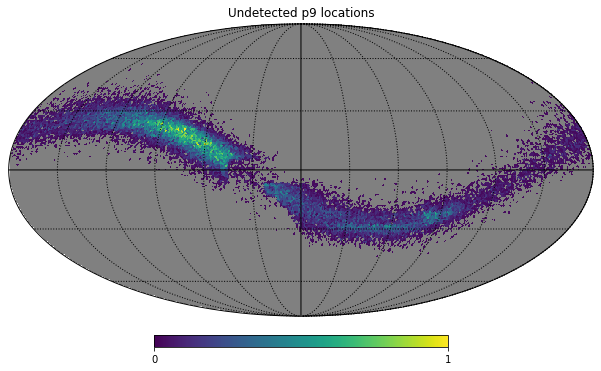

In [41]:
hp.mollview(np.where(p9map>0, p9map, np.nan), min=0, max=1, title="Undetected p9 locations",
           flip='astro')
hp.graticule()

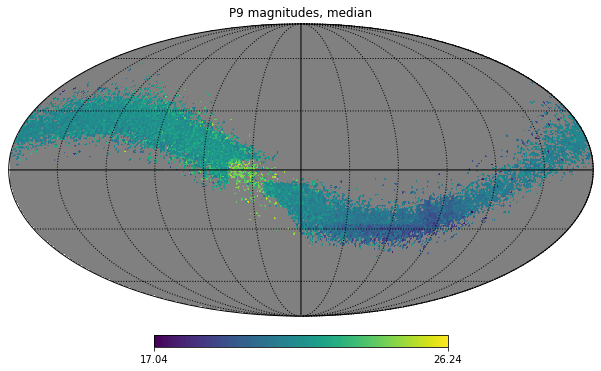

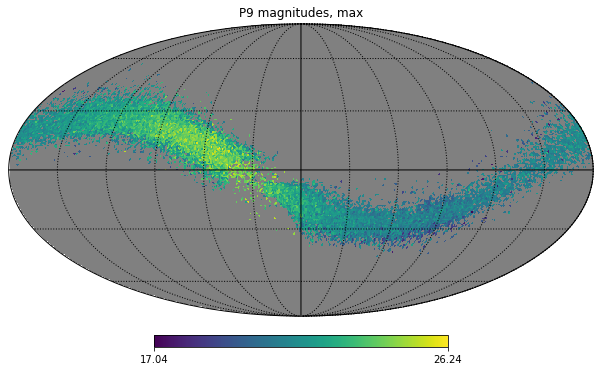

In [42]:
# We can also look at the expected magnitude distribution of the objects in these places 
p9mags_med, bb, bn = binned_statistic(undetected.hpid, undetected.V, statistic='median', 
                             bins=np.arange(0, hp.nside2npix(nside)+1))
hp.mollview(p9mags_med, flip='astro', title='P9 magnitudes, median')
hp.graticule()

p9mags_max, bb, bn = binned_statistic(undetected.hpid, undetected.V, statistic='max', 
                             bins=np.arange(0, hp.nside2npix(nside)+1))
hp.mollview(p9mags_max, flip='astro', title='P9 magnitudes, max')
hp.graticule()

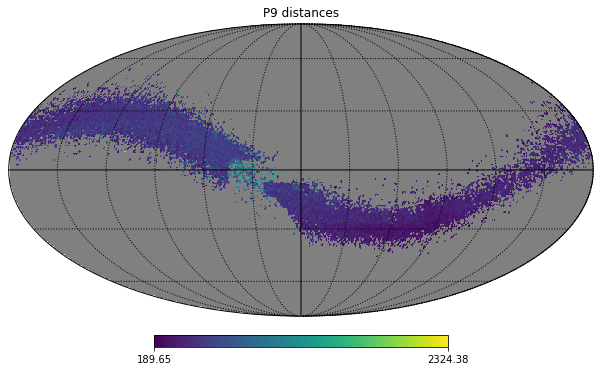

In [43]:
# For funsies .. what's the median distance?
p9dist_med, bb, bn = binned_statistic(undetected.hpid, undetected.R, statistic='median', 
                             bins=np.arange(0, hp.nside2npix(nside)+1))
hp.mollview(p9dist_med, flip='astro', title='P9 distances')
hp.graticule()

Text(0.5, 0, 'Distance (AU)')

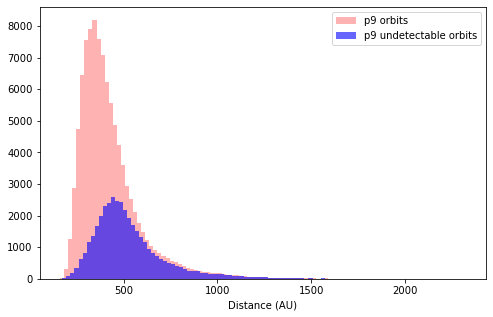

In [44]:
plt.figure(figsize=(8, 5))
j = plt.hist(orbits.R, bins=100, color='r', alpha=0.3, label='p9 orbits')
j = plt.hist(undetected.R, bins=100, color='b', alpha=0.6, label='p9 undetectable orbits')
plt.legend()
plt.xlabel('Distance (AU)')

Text(0.5, 0, 'Magnitude distribution (V)')

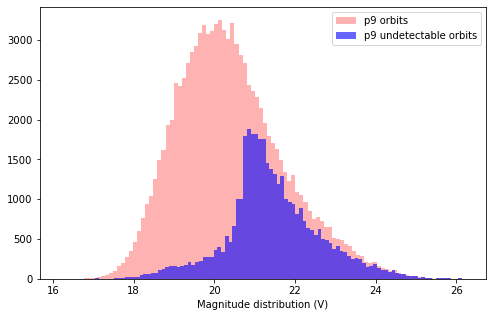

In [45]:
plt.figure(figsize=(8, 5))
j = plt.hist(orbits.V, bins=100, color='r', alpha=0.3, label='p9 orbits')
j = plt.hist(undetected.V, bins=100, color='b', alpha=0.6, label='p9 undetectable orbits')
plt.legend()
plt.xlabel('Magnitude distribution (V)')


In [14]:
# Add the LSST footprint. 
# A relevant value would be the median single image depth, so why not pull that in, in particular. 
# (we can always go and put magnitude limits on the p9 locations from above)

opsdb = '/Users/lynnej/opsim/v2.1/baseline_v2.1_10yrs.db'
# Or please download from 
# https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs2.1/baseline/baseline_v2.1_10yrs.db
runName = 'baseline_v2.1_10yrs'

sql = 'filter == "r"'
m = maf.MedianMetric(col='fiveSigmaDepth')
m2 = maf.Coaddm5Metric()
s = maf.HealpixSlicer(nside=nside)

bundle = maf.MetricBundle(m, s, sql, runName=runName)
bundle2 = maf.MetricBundle(m2, s, sql, runName=runName)

sql2 = 'filter == "r" and night < 365'
bundle3 = maf.MetricBundle(m2, s, sql2, runName=runName)

g = maf.MetricBundleGroup({'s': bundle, 'c': bundle2, 'f': bundle3}, opsdb)
g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with constraint filter == "r" and night < 365 for columns ['fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'fieldRA']
Found 45934 visits
Running:  ['f']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter == "r" for columns ['fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'fieldRA']
Found 466186 visits
Running:  ['s', 'c']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


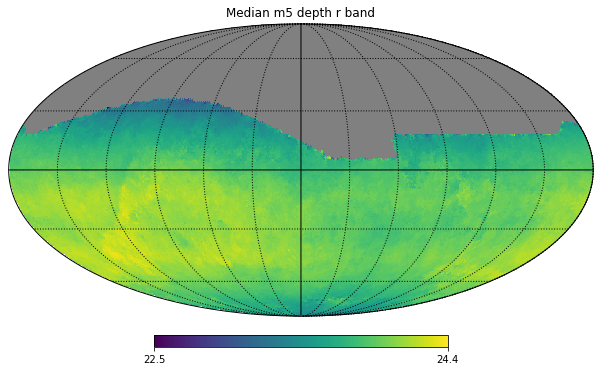

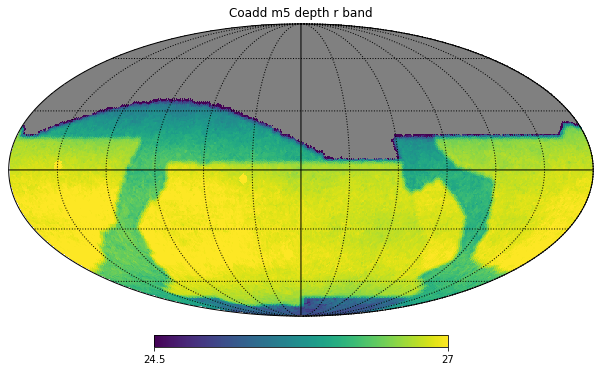

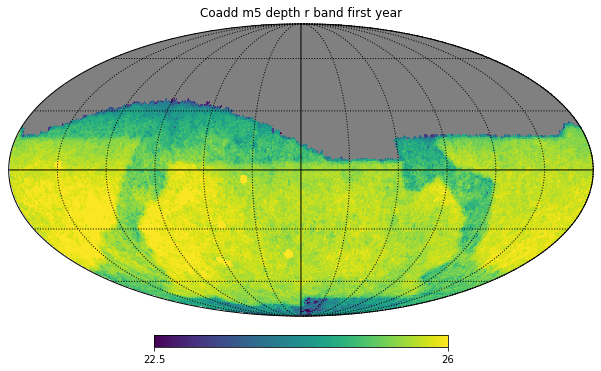

In [15]:
# We usually pretty this up in MAF, but for reference purposes for others .. 
hp.mollview(bundle.metricValues.filled(hp.UNSEEN), flip='astro', title='Median m5 depth r band',
           min=22.5, max=24.4)
hp.graticule()

hp.mollview(bundle2.metricValues.filled(hp.UNSEEN), flip='astro', title='Coadd m5 depth r band',
           min=24.5, max=27)
hp.graticule()

hp.mollview(bundle3.metricValues.filled(hp.UNSEEN), flip='astro', title='Coadd m5 depth r band first year',
           min=22.5, max=26)
hp.graticule()

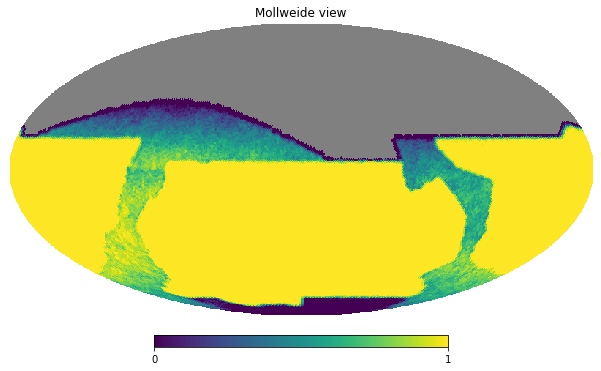

In [16]:
lsstdepths = bundle2.metricValues.filled(np.nan)
hp.mollview(lsstdepths - 25.5, min=0, max=1)

In [55]:
# What fraction of orbits - @start, then @undetected, within the footprint of @ lsst
# and then within footprint & brighter than first year coadd 

print("Without LSST: ", len(orbits), len(undetected), '= ', len(undetected)/len(orbits), ' remaining without LSST')

lsstdepths = bundle2.metricValues.filled(np.nan)

lsst_detectable = undetected.copy()
lsst_detectable['inFP'] = np.zeros(len(lsst_detectable), int)
lsst_detectable['aboveLimit'] = np.zeros(len(lsst_detectable), int)

def check_footprint(row, lsstdepths):
    idx = int(row['hpid'])
    if not np.isnan(lsstdepths[idx]):
        row['inFP'] = 1
        if row['V'] < lsstdepths[idx]:
            row['aboveLimit'] = 1
    return row

lsst_detectable = lsst_detectable.apply(check_footprint, axis=1, args=[lsstdepths])

N_inFP =  len(lsst_detectable.query('inFP == 1'))
N_bright = len(lsst_detectable.query('aboveLimit == 1'))
N_left = len(undetected) - N_inFP

print(f"With LSST - {N_inFP} are in the footprint, or {N_inFP / len(orbits)} of original")
print(f"With LSST - {N_bright} are in the footprint and above the first year coadded magnitude limit, or "
      f"{N_bright / len(orbits)} of the total")

print(f"This leaves {N_left} remaining ({N_left / len(orbits)} of original 100,000), "
      f"or {N_left / len(undetected)} of current potential orbits")

Without LSST:  100000 38794 =  0.38794  remaining without LSST
With LSST - 36775 are in the footprint, or 0.36775 of original
With LSST - 36772 are in the footprint and above the first year coadded magnitude limit, or 0.36772 of the total
This leaves 2019 remaining (0.02019 of original 100,000), or 0.052044130535649845 of current potential orbits


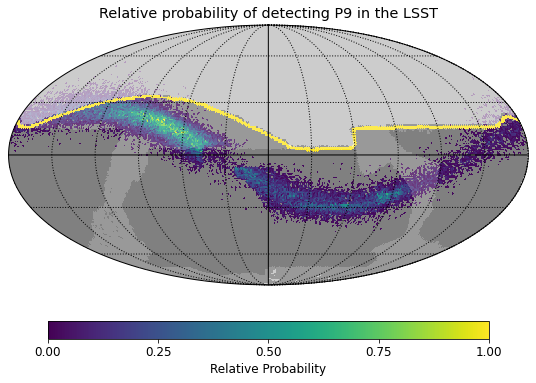

In [56]:
# We could put these together and stuff into a MAF slicer, for easier / prettier plotting
# Or try using skyproj, which also remaps some of the healpy plotting 
# But, because I think you might like to remake this for paper purposes, I'll just put them together in healpy 
# directly, as that may be easier to override with matplotlib.

lsstdepths = bundle2.metricValues.filled(np.nan)  # coadded depth 
p9positions = p9map 

# Set up a 'background'  
alpha = np.where(lsstdepths > 24, 1, 0.8)  # basic on/off 

alpha = np.zeros(len(lsstdepths)) + 0.4  # more complex WFD/other
alpha = np.where(lsstdepths > 25, 0.8, alpha)
alpha = np.where(lsstdepths > 26.5, 1, alpha)

# We could try this for an outline .. 
outline = np.where(lsstdepths > 24, 1, 0)
outline = hp.smoothing(outline, fwhm=0.1, nest=False)
outline = np.where((outline<0.9) & (outline > 0.7), 1, 0)


# Make figure (without colorbar)
combo = p9positions + outline * 3
combo = np.where(combo <=0, np.nan, combo)

hp.mollview(combo, min=0, max=1, alpha=alpha,
           cbar=False)
hp.graticule(dpar=30, dmer=30)

# Replace colorbar
ax = plt.gca()
im = ax.get_images()[0]

cb = plt.colorbar(im,
                    shrink=0.75,
                    aspect=25,
                    pad=0.1,
                    orientation="horizontal",
                    extendrect=True,
                )
cb.set_label("Relative Probability", fontsize='large')
cb.ax.tick_params(labelsize='large')
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
plt.title("Relative probability of detecting P9 in the LSST", fontsize='x-large')
plt.savefig('p9_prob_rubin.pdf')